**Create Train generator and val generator**

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
def adjustData(img,mask, num_class = 23):
  img = img.astype(np.float32)
  img/= 255.0
  new_mask = np.zeros((mask.shape[0],mask.shape[1], mask.shape[2], num_class))
  for i in range(mask.shape[0]):
    this_mask = mask[i,:,:,0]
    for c in range(num_class):
      new_mask[i,:,:,c] = (this_mask == c).astype('int')
    return img, new_mask
def trainGenerator(batch_size,train_path,image_folder,mask_folder,aug_dict,image_color_mode = "rgb",
                    mask_color_mode = "grayscale",image_save_prefix  = "image",mask_save_prefix  = "mask",
                    flag_multi_class = False,num_class = 23,save_to_dir = None,target_size = (256,256),seed = 1):
    '''
    can generate image and mask at the same time
    use the same seed for image_datagen and mask_datagen to ensure the transformation for image and mask is the same
    if you want to visualize the results of generator, set save_to_dir = "your path"
    '''
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    image_generator = image_datagen.flow_from_directory(
        train_path,
        classes = [image_folder],
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)
    mask_generator = mask_datagen.flow_from_directory(
        train_path,
        classes = [mask_folder],
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)
    train_generator = zip(image_generator, mask_generator)
    for (img,mask) in train_generator:
       
        img,mask = adjustData(img,mask,num_class)
        yield (img,mask)
def valGenerator(val_path,image_folder = 'image', mask_folder= 'mask' ,num_class = 23,image_color_mode = 'rgb',mask_color_mode = 'grayscale',
                  batch_size = 5,target_size = (256,256), seed = 1):
  
  image_datagen = ImageDataGenerator()
  mask_datagen  = ImageDataGenerator()
  image_generator = image_datagen.flow_from_directory(val_path, 
                                                      classes = [image_folder],
                                                      color_mode = image_color_mode,
                                                      class_mode = None,
                                                      target_size = target_size,
                                                      batch_size = batch_size,
                                                      seed = seed)
  mask_generator = mask_datagen.flow_from_directory(val_path, 
                                classes = [mask_folder],
                                color_mode = mask_color_mode, 
                                class_mode = None, 
                                target_size = target_size,
                                batch_size = batch_size,
                                seed = seed
                                )
  val_generator = zip(image_generator, mask_generator)
  for (img,mask) in val_generator:
    img,mask = adjustData(img, mask, num_class = num_class)
    yield (img, mask)



Using TensorFlow backend.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
args = dict(rotation_range = 0.1, width_shift_range = 0.1,height_shift_range = 0.1, shear_range=0.1, zoom_range = 0.1, vertical_flip = True, horizontal_flip = True, )
#args = dict()
train_generator_ = trainGenerator(10, '/content/drive/My Drive/data/train/', 'image','mask', args,num_class = 23 ,image_color_mode='rgb', target_size = (256,256) )
val_generator_ = valGenerator('/content/drive/My Drive/data/test/','image', 'mask',23 , image_color_mode='rgb', target_size = (256,256),batch_size=10) 


**Create Unet with VGG16 encoder**

In [ ]:
from keras.models import *
from keras.layers import *
from keras.applications.vgg16 import VGG16 as vgg16
from keras.metrics import MeanIoU as iou
from keras.optimizers import Adam
from keras.backend import clear_session
clear_session()
def pretrained_encoder_unet( input_shape = (256,256,3)):
  encoder = vgg16(input_shape =input_shape,include_top = False, weights = 'imagenet')
  #CONTRACTING PATH
  #input (256,256,3)
  inputs = encoder.layers[0].output
  block1_conv1 = encoder.layers[1].output
  block1_conv2 = encoder.layers[2].output
  block1_pool = encoder.layers[3].output
  #(128,128,64)
  block2_conv1 = encoder.layers[4].output
  block2_conv2 = encoder.layers[5].output
  block2_pool = encoder.layers[6].output
  #(64,64,128)
  block3_conv1 = encoder.layers[7].output
  block3_conv2 = encoder.layers[8].output
  block3_conv3 = encoder.layers[9].output
  block3_pool = encoder.layers[10].output
  #(32,32,256)
  block4_conv1 = encoder.layers[11].output
  block4_conv2 = encoder.layers[12].output
  block4_conv3 = encoder.layers[13].output
  block4_pool = encoder.layers[14].output
  #(16,16,512)


  #EXPANSIVE PART
  #(16,16,512)

  up1 =Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(block4_pool) 
  #(32,32,256)
  up1 = concatenate([up1, block4_conv3])# up1(32,32,256)  concatenate with (32,32,512)  = (32,32,768)
  conv1 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(up1) # (32,32,256)
  drop1 = Dropout(0.0)(conv1)
  conv1 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(drop1)
  conv1 = BatchNormalization()(conv1)
  #(32,32,256)
  up2 = Conv2DTranspose(128, (2,2), strides = (2,2), padding = 'same')(conv1)
  #(64,64,128)
  up2 = concatenate([up2, block3_conv3 ]) # up2(64,64,128) concatenate with (64,64,512) = (64,64,640)
  conv2 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(up2)
  #(64,64,128)
  drop2 = Dropout(0.0)(conv2)
  conv2 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(drop2)
  conv2 = BatchNormalization()(conv2)
  #(64,64,128)
  up3 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv2)
  #(128,128,64)
  up3 = concatenate([up3,block2_conv2]) #up3(128,128,64) concatenate with (128,128,256) = (128,128,320)
  conv3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(up3)
  drop3 = Dropout(0.0)(conv3)
  conv3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(drop3)
  conv3 = BatchNormalization()(conv3)
  #(128,128,64)
  up4 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv3)
  #(256,256, 32)
  up4 = concatenate([up4,block1_conv2 ]) #up4(256,256,32) concatenate with (256,256,128) = (256,256,160)
  conv4 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(up4)
  drop4 = Dropout(0.0)(conv4)
  conv4 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(drop4)
  conv4 = BatchNormalization()(conv4)


  outputs = Conv2D(23,(3,3), activation = 'softmax', padding = 'same')(conv4)
  model = Model(input= [inputs], output = [outputs])
  for i, layer in enumerate(model.layers):
    if i< 15:
      model.layers[i].trainable = False
  model.compile(optimizer ='adam', loss = 'categorical_crossentropy')
  model.summary()
  return model

In [ ]:
unet = pretrained_encoder_unet()

58892288/58889256 [==============================] - 5s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 256, 256, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 128, 128, 64) 0           block1_conv2[0][0]               
___________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:79: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`


**Create callbacks and train model**

In [ ]:
from keras.callbacks import ModelCheckpoint
model_checkpoint = ModelCheckpoint(filepath = '/content/model_valloss_categorical_crossentropy.ckpt',
                                   save_weights_only =True,
                                   monitor = 'val_loss',
                                   mode = 'min',
                                   save_best_only =  True)

In [ ]:
#unet.compile(optimizer = Adam(learning_rate = 0.0001), loss = 'categorical_crossentropy')
history = unet.fit(train_generator_, epochs =20,steps_per_epoch= 50, 
                              callbacks = [model_checkpoint], validation_data = val_generator_, validation_steps = 5)



**Load all val images and val masks into ram and test it with iou**

In [ ]:
import os
import cv2
def get_pairs_from_path(images_path, masks_path ):
  """Find all the images on the image directory and all the masks in the mask directory"""
  image_files = []
  mask_files = {}
  #gan cac tuples chua (filename, file_extension, path of image) vao image_file
  for dir_entry in os.listdir(images_path):
    filename, file_extension = os.path.splitext(dir_entry)
    image_files.append((filename, file_extension, os.path.join(images_path, dir_entry)))
  #gan cac key va value la filename va (file_extension, mask_path) vao dict mask_files
  for dir_entry in os.listdir(masks_path):
    filename, file_extension = os.path.splitext(dir_entry)
    mask_path = os.path.join(masks_path, dir_entry)
    mask_files[filename] = (file_extension, mask_path)
  return_values = []
  #match image and mask
  #gan vao return_values cac tuple chua cac cap(image_path, mask_path) phu hop
  for image_name, _, image_path in image_files:
    if image_name in mask_files:
      return_values.append((image_path, mask_files[image_name][1]))
  return return_values

def get_image_array(image_input, size):
  #load image array from image_input
  img = cv2.imread(image_input, 1)
  img = cv2.resize(img,  size)
  img = img/255.0
  return img
def get_mask_array(mask_input, size):
  mask = cv2.imread(mask_input, 0)
  mask = cv2.resize(mask, size)
  return mask

def get_numpy_data(images_path, masks_path, size = (256,256)):
  image_mask_pairs = get_pairs_from_path(images_path, masks_path)
  images = []
  masks = []
  for img,mask in image_mask_pairs:
    images.append(get_image_array(img, size = size))
    masks.append(get_mask_array(mask, size = size))
  return np.array(images), np.array(masks)

In [ ]:
val_images, val_masks = get_numpy_data('/content/drive/My Drive/data/test/image', '/content/drive/My Drive/data/test/mask')

In [ ]:
def my_iou_scores(model, val_images, val_masks, num_classes):
  onehot_predictions = model.predict(val_images)
  predictions = np.argmax(onehot_predictions, axis = 3)
  onehot_predictions = np.zeros(shape = (val_masks.shape[0], val_masks.shape[1], val_masks.shape[2], num_classes))
  for i in range(0, val_masks.shape[0]):
    for c in range(0,num_classes):
      onehot_predictions[i,:,:,c] = (predictions[i,:,:,] == c).astype('int')
  onehot_val_masks = np.zeros(shape = (val_masks.shape[0], val_masks.shape[1], val_masks.shape[2], num_classes))
  for i in range(0,val_masks.shape[0]):
    for c in range(0,num_classes):
      onehot_val_masks[i,:,:,c] = (val_masks[i,:,:,] == c).astype('int')
  assert onehot_predictions.shape == onehot_val_masks.shape
  for i in range(0, onehot_val_masks.shape[0]):
    intersection = np.sum(np.logical_and(onehot_predictions[i,:,:,:,], onehot_val_masks[i,:,:,:,]))
    union = np.sum(np.logical_or(onehot_predictions[i,:,:,:,], onehot_val_masks[i,:,:,:,]))
  return intersection/union

In [ ]:
my_iou_scores(unet, val_images, val_masks,23)

0.47088462703818834

In [ ]:
def my_accuracy_scores(model, val_images, val_masks):
  onehot_predictions = model.predict(val_images)
  predictions = np.argmax(onehot_predictions, axis = 3)
  accuracy = []
  for i in range(0,val_images.shape[0]):
    acc = 0
    for x,y in zip(np.nditer(predictions[i,:,:,]),np.nditer(val_masks[i,:,:,]) ):
      if x == y:
        acc  += 1
    accuracy.append(acc/(val_images.shape[1]*val_images.shape[2]))
  return np.mean(accuracy)


In [ ]:
my_accuracy_scores(unet, val_images, val_masks)

0.531810302734375

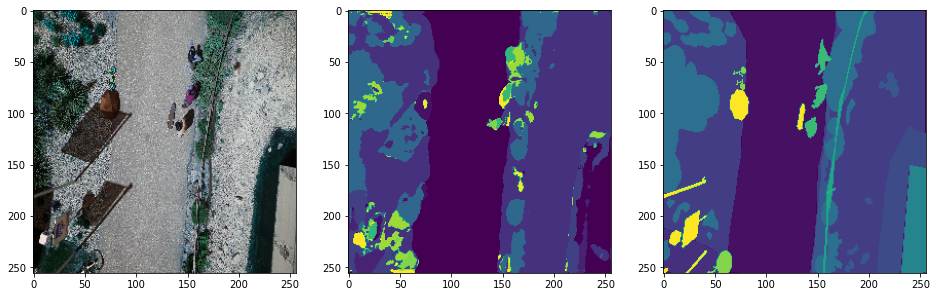

In [ ]:
import matplotlib.pyplot as plt
p = unet.predict(val_images)
fig,axs = plt.subplots(1,3,figsize = (16,9))
o = 34
axs[0].imshow(val_images[o,:,:,:,])
axs[1].imshow(np.argmax(p[o,:,:,:,], axis = 2))
axs[2].imshow(val_masks[o,:,:,])

In [ ]:
unet.save_weights('unet_categorical_crossentrpy_iou_40_epochs_trained.ckpt')

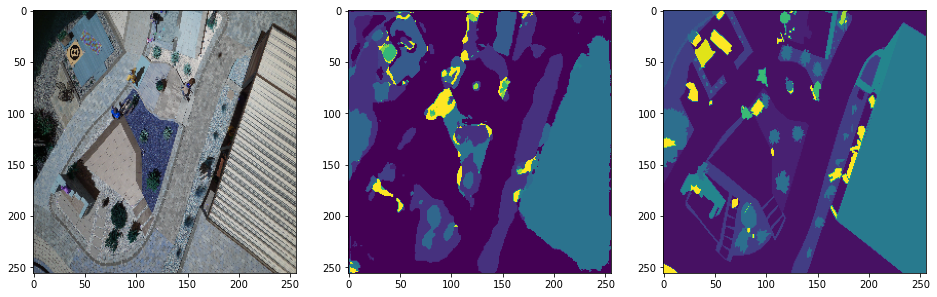

In [ ]:

fig,axs = plt.subplots(1,3,figsize = (16,9))
o = 7
axs[0].imshow(val_images[o,:,:,:,])
axs[1].imshow(np.argmax(p[o,:,:,:,], axis = 2))
axs[2].imshow(val_masks[o,:,:,])

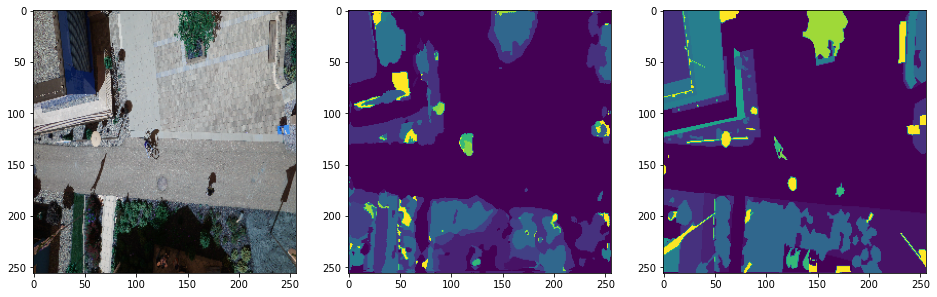

In [ ]:

fig,axs = plt.subplots(1,3,figsize = (16,9))
o = 13
axs[0].imshow(val_images[o,:,:,:,])
axs[1].imshow(np.argmax(p[o,:,:,:,], axis = 2))
axs[2].imshow(val_masks[o,:,:,])

In [ ]:
unet.load_weights('/content/BEST_VGGUnet_V1_val_loss_053_iou.ckpt')